In [1]:
# docker run -it -p 8888:8888 jupyter/all-spark-notebook

In [6]:
# !pip install delta-spark

from delta import *

from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.types import *
from pyspark.sql.types import _parse_datatype_json_string

from pyspark.sql.column import Column, _to_java_column
from pyspark.sql.types import StructType
from pyspark.sql.utils import *
import pyspark.sql.functions as F

import os
import urllib.request

## Jar files for XML

In [15]:
url = "https://repo1.maven.org/maven2/com/databricks/spark-xml_2.12/0.16.0/spark-xml_2.12-0.16.0.jar"
# destination = "/home/jovyan/.ivy2/jars/spark-xml_2.12-0.16.0.jar"
destination = "jars/spark-xml_2.12-0.16.0.jar"

urllib.request.urlretrieve(url, destination)

('jars/spark-xml_2.12-0.16.0.jar', <http.client.HTTPMessage at 0x7f81941bdd90>)

In [16]:
ticket_fees = [{'type':'base', 'value':30},
               {'type':'base + school zone','value': 60},
               {'type':'base + construction work zone','value':60},
               {'type':'base + school zone + construction work zone', 'value':120}]

keywords = ['automobiles', 'people', 'speeding_tickets']

path = './work/ttpd_data'
all_files = [os.path.join(path, f) for f in os.listdir(path) if os.path.isfile(os.path.join(path, f))]
# all_files

# Functions

In [17]:
# XML is not included in the Python release it seems, only Scala
# https://github.com/databricks/spark-xml
# https://stackoverflow.com/questions/64934508/parsing-xml-columns-from-pyspark-dataframe-using-udf
def ext_from_xml(xml_column, schema, options={}):
    java_column = _to_java_column(xml_column.cast('string'))
    java_schema = spark._jsparkSession.parseDataType(schema.json())
    scala_map = spark._jvm.org.apache.spark.api.python.PythonUtils.toScalaMap(options)
    jc = spark._jvm.com.databricks.spark.xml.functions.from_xml(java_column, java_schema, scala_map)
    return Column(jc)

def ext_schema_of_xml_df(df, options={}):
    assert len(df.columns) == 1

    scala_options = spark._jvm.PythonUtils.toScalaMap(options)
    java_xml_module = getattr(getattr(spark._jvm.com.databricks.spark.xml, "package$"), "MODULE$")
    # print(java_xml_module)
    java_schema = java_xml_module.schema_of_xml_df(df._jdf, scala_options)
    # print(java_schema)
    
    return _parse_datatype_json_string(java_schema.json())

In [18]:
def __get_spark_session__() -> SparkSession:
    builder = SparkSession \
        .builder \
        .appName('takehome') \
        .config("spark.jars", destination) \
        .config("spark.sql.extensions", "io.delta.sql.DeltaSparkSessionExtension") \
        .config("spark.sql.catalog.spark_catalog", "org.apache.spark.sql.delta.catalog.DeltaCatalog") \
        
    
    return configure_spark_with_delta_pip(builder).getOrCreate()


def __read_file__(spark, file_path):
    
    if file_path.endswith('.xml'):
        # print(f'Reading XML file {file_path}')
        
        df = spark.read.format("binaryFile").load(file_path).selectExpr("CAST(content AS STRING)")
        xml_extraction_options = {"mode": "DROPMALFORMED","inferSchema":"true"}
        xml_schema = ext_schema_of_xml_df(df.select("content"), xml_extraction_options)
        # print(xml_schema)
        df_parsed = df.withColumn("parsed", ext_from_xml(F.col("content"), xml_schema))
        # df_parsed.show()
        df2 = df_parsed.select(*df_parsed.columns[:-1],F.explode(F.col('parsed').getItem('automobile')))
        # df2.show()
        new_col_names = [s.split(':')[0] for s in xml_schema['automobile'].simpleString().split('<')[-1].strip('>>').split(',')]
        # print(new_col_names)
        for c in new_col_names:
            df2 = df2.withColumn(c, F.col('col').getItem(c))
        df2 = df2.drop('col','_VALUE')

        return df2

    elif file_path.endswith('.json'):
        # print(f'Reading JSON file {file_path}')
        df = spark.read.json(file_path)
        if 'speeding_tickets' in df.columns:
            df = df.select(explode(col('speeding_tickets')).alias('ticket')).select('ticket.*')
        return df
        
    elif file_path.endswith('.csv'):
        # print(f'Reading CSV file {file_path}')
        return spark.read.csv(file_path, header=True, inferSchema=True,sep='|')
    else:
        return None


def __combine_files__(spark, keyword):
    filtered_files = [f for f in all_files if keyword in f]
    if not filtered_files:
        return None

    dataframes = [__read_file__(spark, f) for f in filtered_files if __read_file__(spark, f) is not None]
    if not dataframes:
        return None

    combined_df = dataframes[0]
    for df in dataframes[1:]:
        combined_df = combined_df.union(df)
    return combined_df


def main():
    spark = __get_spark_session__()
    print(f'Spark Session Initialized...')

    combined_dfs = {keyword: __combine_files__(spark, keyword) for keyword in keywords}

    for keyword, df in combined_dfs.items():
        if df is not None:
            print(f"Combined DataFrame for {keyword}:")
            df.show()
        else:
            print(f"No files found for keyword: {keyword}")
    return combined_dfs

# Data Ingestion

In [19]:
spark = __get_spark_session__() # not getting passed into UDFs correctly??
dfs = main()

Spark Session Initialized...
Combined DataFrame for automobiles:
+--------------------+-------------+-------------+--------------------+-----------------+----+
|             content|        color|license_plate|           person_id|              vin|year|
+--------------------+-------------+-------------+--------------------+-----------------+----+
|<?xml version="1....|   SandyBrown|      QFF 087|dfa9aed5-7172-4e9...|CL6TK95K73FE5SHXT|1982|
|<?xml version="1....|LavenderBlush|        3Q380|ba743372-658b-48c...|WPCAK8EK7EH8VW3YS|2023|
|<?xml version="1....|  ForestGreen|      CLT 179|ba743372-658b-48c...|EJ90XVM508JD3FUDV|2019|
|<?xml version="1....|         Snow|      38R E99|ba743372-658b-48c...|ECBGKDYM89G9HBGER|1980|
|<?xml version="1....|       Purple|     62-13425|829a6ec5-6bc2-4ee...|AD075YPR3LNRSYDPH|1977|
|<?xml version="1....|    LawnGreen|      467-IHF|56b147ea-8c68-494...|PDD6NEU28YM141FAX|2009|
|<?xml version="1....|       Yellow|        0DM43|56b147ea-8c68-494...|1Z9CHB950

# EDA

In [20]:
st = dfs['speeding_tickets']
dedup_st = st.dropDuplicates()
print(f"Ingested {st.count()} Speeding Ticket records")
print(f"Ingested {st.count() - dedup_st.count()} duplicate records")

p = dfs['people']
dedup_p = p.dropDuplicates()
print(f"Ingested {p.count()} People records")
print(f"Ingested {p.count() - dedup_p.count()} duplicate records")

a = dfs['automobiles']
dedup_a = a.dropDuplicates()
print(f"Ingested {a.count()} Automobile records")
print(f"Ingested {a.count() - dedup_a.count()} duplicate records")

Ingested 16123 Speeding Ticket records
Ingested 0 duplicate records
Ingested 7123 People records
Ingested 0 duplicate records
Ingested 10299 Automobile records
Ingested 0 duplicate records


## Label our ticket valuations

In [21]:
fee_df = spark.createDataFrame(ticket_fees)
fee_df.show()

st = st.withColumn(
    'ticket_value',
    when((col('school_zone_ind') == True) & (col('work_zone_ind') == True), 120)
    .when((col('school_zone_ind') == True) | (col('work_zone_ind') == True), 60)
    .otherwise(30)
)

st = st.withColumn('clean_license_plate', upper(trim(st['license_plate'])))
st.show()

+--------------------+-----+
|                type|value|
+--------------------+-----+
|                base|   30|
|  base + school zone|   60|
|base + constructi...|   60|
|base + school zon...|  120|
+--------------------+-----+

+--------------------+-------------+--------------------+-----------------------+---------------+-----------+-------------------+-------------+------------+-------------------+
|                  id|license_plate|          officer_id|recorded_mph_over_limit|school_zone_ind|speed_limit|        ticket_time|work_zone_ind|ticket_value|clean_license_plate|
+--------------------+-------------+--------------------+-----------------------+---------------+-----------+-------------------+-------------+------------+-------------------+
|e937ade8-7e56-4b2...|      026 GIT|b304a890-64cf-44d...|                     11|          false|         15|2023-08-31 05:28:56|        false|          30|            026 GIT|
|b7d80f56-6f96-480...|      VEF 900|e2155846-cecb-471...|  

## 1. Who are the Police Officers

In [45]:
# Find our Officers in Person
print('Our Top profession by volume appears to be Police Officer')
p.groupBy('profession').agg(count('id').alias('count')).orderBy(desc('count')).show()
print('When we regex search for police we return 55 values')
p.filter(col("profession").rlike("(?i)police")).distinct().count()

Our Top profession by volume appears to be Police Officer
+--------------------+-----+
|          profession|count|
+--------------------+-----+
|      Police Officer|   42|
|      Engineer, site|   23|
|Private music tea...|   22|
|Engineer, agricul...|   22|
|    Health physicist|   21|
|        Risk analyst|   21|
|                Copy|   21|
|    Marine scientist|   20|
|Teaching laborato...|   19|
| Information officer|   19|
|         Firefighter|   19|
|    Sports therapist|   19|
| Geologist, wellsite|   19|
|Primary school te...|   19|
|Planning and deve...|   18|
|IT technical supp...|   18|
|  Wellsite geologist|   18|
|Engineer, control...|   18|
|Chief Marketing O...|   18|
|Health service ma...|   18|
+--------------------+-----+
only showing top 20 rows

When we regex search for police we return 55 values


55

### Big O v little o

In [50]:
p.filter(col("profession").rlike("(?i)police")).groupBy('profession').agg(count('id').alias('count')).orderBy(desc('count')).show()

+--------------+-----+
|    profession|count|
+--------------+-----+
|Police Officer|   42|
|Police officer|   13|
+--------------+-----+



In [23]:
# Label our officers in speeding_tickets df
print(st.agg(countDistinct('officer_id')).collect())

joined_df = st.join(p, st.officer_id == p.id, 'left').select(
    st['*'],
    p['first_name'].alias('officer_first_name'),
    p['last_name'].alias('officer_last_name'))


officers = joined_df.withColumn('officer_full_name', concat_ws(' ', joined_df.officer_first_name, joined_df.officer_last_name))

print(f"We see {officers.select('officer_full_name').distinct().count()} officers issuing speeding tickets")


officers.select('officer_full_name').distinct().show()

[Row(count(DISTINCT officer_id)=42)]
We see 42 officers issuing speeding tickets
+-----------------+
|officer_full_name|
+-----------------+
|   Cynthia Suarez|
|   Steven Harding|
|    Scott Aguirre|
|     Steven Rojas|
|      Louis Drake|
|     Brian Cannon|
|  Crystal Goodwin|
|  Kenneth Gardner|
|      Ethan Lopez|
|   Kimberly Smith|
|    John Mcdaniel|
|     Eric Marquez|
|      Erica Brown|
|    Angela Martin|
|       Jaime Ward|
|   David Peterson|
|      Martin Dean|
|      Kevin Perez|
|    Michelle Gray|
|        Anna Ryan|
+-----------------+
only showing top 20 rows



## 2. Which officer handed out the most speeding tickets?

In [24]:
o_cnt = officers.groupby('officer_full_name').count().orderBy(desc('count'))
top_o = o_cnt.first()
print(f"By volume we can see {top_o['officer_full_name']} issued the most tickets with {top_o['count']}")

By volume we can see Barbara Cervantes issued the most tickets with 419


## 3. What 3 months had the most speeding tickets?
    - Month-to-month and Year-to-Year

In [25]:
joined_df = joined_df.withColumn('year', year('ticket_time'))
joined_df = joined_df.withColumn('year_month', date_format('ticket_time', 'yyyy-MM'))

In [26]:
yearly = joined_df.groupBy('year').agg(count('ticket_time').alias('ticket_count')).orderBy(desc('year'))
monthly = joined_df.groupBy('year_month').agg(count('ticket_time').alias('ticket_count')).orderBy(desc('year_month'))

print("We can see a large jump in tickets being issued from 2022 to 2023")
# Our data is only within our window 2020-2023
yearly.show()

We can see a large jump in tickets being issued from 2022 to 2023
+----+------------+
|year|ticket_count|
+----+------------+
|2023|        6422|
|2022|        4077|
|2021|        4023|
|2020|        1601|
+----+------------+



In [27]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

monthly_pdf = monthly.toPandas()


print(f"We see that the months of December in 21' to 23' was the Top 3 most ticketed months.")
monthly_pdf.sort_values('ticket_count',ascending=False).head(3)

We see that the months of December in 21' to 23' was the Top 3 most ticketed months.


,year_month,ticket_count
0,2023-12,1258
12,2022-12,824
24,2021-12,803


### Trending Ticket Volumes

We can see spikes around the new year(December-January) and in October of each year


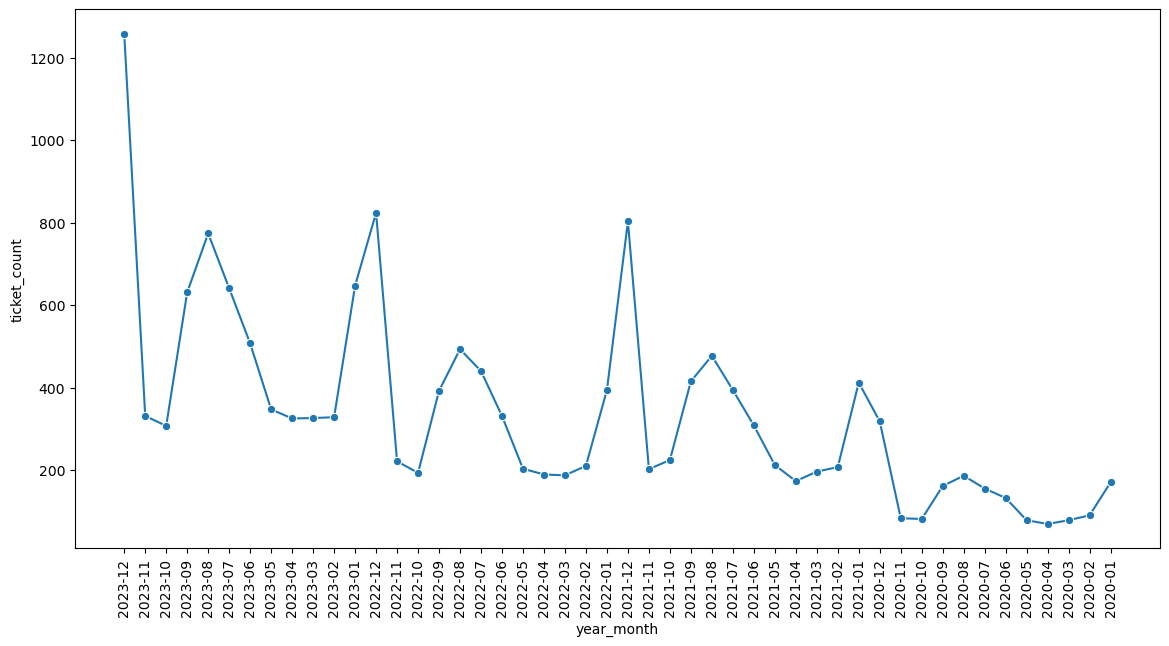

In [28]:
print(f"We can see spikes around the new year(December-January) and in October of each year")


plt.figure(figsize=(14, 7))
plt = sns.lineplot(data=monthly_pdf, x='year_month', y='ticket_count', marker='o')
plt.tick_params(axis='x', rotation=90)

## 4. Top 10 people who have spent the most on speeding tickets

In [29]:
# Quick and dirty for speeding_tickets/officer labeling didnt pay off :)
# Send the flag to the people
o_ids = st.select('officer_id').distinct()

p_cop_joined_df = p.join(o_ids, p.id == o_ids.officer_id, 'left').select(
    p['*'],
    o_ids['officer_id'])

# 42 officers labeled
print(p_cop_joined_df.filter(p_cop_joined_df.officer_id.isNotNull()).count())

# Checksum for the total people
print(p_cop_joined_df.count())

42
7123


In [30]:
# Combine with automobiles for totals by people
# Check if id in speeding_ticket is PK
st.select('id').count()
# We must join on license plate

16123

In [56]:
# Skinny df for calculations
master_df = p_cop_joined_df.join(a, p_cop_joined_df.id == a.person_id, 'left').select(
    p_cop_joined_df['first_name'],
    p_cop_joined_df['last_name'],
    p_cop_joined_df['officer_id'],
    p_cop_joined_df['profession'],
    a['license_plate'])

master_df = master_df.withColumn('full_name', concat_ws(' ', master_df.first_name, master_df.last_name))
master_df = master_df.withColumn('clean_license_plate', upper(trim(master_df['license_plate'])))

master_df = master_df.select('officer_id','full_name','clean_license_plate','profession')

In [57]:
master_df.show()

+----------+-----------------+-------------------+--------------------+
|officer_id|        full_name|clean_license_plate|          profession|
+----------+-----------------+-------------------+--------------------+
|      NULL|   Kaitlyn Rhodes|            927-GSN| Call centre manager|
|      NULL|   Kaitlyn Rhodes|            57-NC57| Call centre manager|
|      NULL|Jeffrey Hernandez|           DW 09395|Primary school te...|
|      NULL|        Ann Gates|            ZBX-926|Teacher, English ...|
|      NULL|        Ann Gates|            83Y T30|Teacher, English ...|
|      NULL|   Edward Roberts|            407-QXA| Broadcast presenter|
|      NULL|  Katherine Smith|           3M EK392|Sports administrator|
|      NULL|   James Robinson|            FNS3743|Private music tea...|
|      NULL|    Matthew Terry|            CU 7241| Clinical biochemist|
|      NULL|    Jessica Allen|            QGS 230|Nature conservati...|
|      NULL|    Jessica Allen|            321-SUI|Nature conserv

In [58]:
#Skinny Tickets
st_skinny = st.select('clean_license_plate','ticket_value')

In [59]:
master_df = master_df.join(st_skinny, master_df.clean_license_plate == st_skinny.clean_license_plate, 'left').select(
    master_df['*'],
    st_skinny['*'])

master_df.show()

+----------+-----------------+-------------------+--------------------+-------------------+------------+
|officer_id|        full_name|clean_license_plate|          profession|clean_license_plate|ticket_value|
+----------+-----------------+-------------------+--------------------+-------------------+------------+
|      NULL|   Kaitlyn Rhodes|            927-GSN| Call centre manager|            927-GSN|          30|
|      NULL|   Kaitlyn Rhodes|            57-NC57| Call centre manager|            57-NC57|          30|
|      NULL|Jeffrey Hernandez|           DW 09395|Primary school te...|           DW 09395|          60|
|      NULL|Jeffrey Hernandez|           DW 09395|Primary school te...|           DW 09395|          60|
|      NULL|Jeffrey Hernandez|           DW 09395|Primary school te...|           DW 09395|          60|
|      NULL|        Ann Gates|            ZBX-926|Teacher, English ...|            ZBX-926|          30|
|      NULL|        Ann Gates|            83Y T30|Teach

In [60]:
print(f"We can see our Top 10 Ticketed Persons by Total Ticket Valuation")
master_df.groupBy('full_name').agg(F.sum('ticket_value').alias('sum_of_ticket_values')).orderBy(desc('sum_of_ticket_values')).show(10)

We can see our Top 10 Ticketed Persons by Total Ticket Valuation
+-----------------+--------------------+
|        full_name|sum_of_ticket_values|
+-----------------+--------------------+
|    Robert Holmes|                 930|
| Elizabeth Zuniga|                 750|
|      Dylan Davis|                 720|
|    Michael Jones|                 720|
| Rebecca Mcdaniel|                 720|
|   William Morgan|                 690|
|   James Anderson|                 690|
|     Ashley Smith|                 690|
|      David Stone|                 690|
|Alexandra Jackson|                 660|
+-----------------+--------------------+
only showing top 10 rows



## ?2b. Which officer was handed the most speeding tickets?

In [61]:
print(f"We can see our Top 10 Ticketed Officers by Total Ticket Valuation")

o_master_df = master_df.filter(col("profession").rlike("(?i)police"))
o_master_df.groupBy('full_name').agg(F.sum('ticket_value').alias('sum_of_ticket_values')).orderBy(desc('sum_of_ticket_values')).show(10)

We can see our Top 10 Ticketed Officers by Total Ticket Valuation
+-----------------+--------------------+
|        full_name|sum_of_ticket_values|
+-----------------+--------------------+
|  Courtney Riddle|                 360|
|  Richard Mendoza|                 330|
|   Steven Harding|                 240|
|    Rebecca Crane|                 240|
|  Shaffer Wallace|                 240|
|       Mary Terry|                 210|
|    Michelle Gray|                 210|
|       Chad Leach|                 210|
|Barbara Cervantes|                 210|
|    Michael Perez|                 210|
+-----------------+--------------------+
only showing top 10 rows

